# Explore the Asheville Pub Safe Dataset

import python modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

In [2]:
df = pd.read_csv("APD_Public_Incident_Data__Crime_Locations.csv", parse_dates=True)

In [3]:
df.head()

,OBJECTID,incident_id,agency,date_occurred,case_number,address,geo_beat,geo_report_area,x,y,offense_short_description,offense_long_description,offense_code,offense_group_code,offense_group_level,offense_group_short_description,offense_group_long_description
0,109166,465432,APD,2011-02-28T14:32:50.000Z,11005427,100-BLK CHERRY ST N,AB1,A144,942560.94,691554.44,VANDALISM,VANDALISM,1400.0,14,Part II,VANDALISM,"To willfully or maliciously destroy, damage, d..."
1,109167,475711,APD,2011-05-17T20:11:31.000Z,11013040,100-BLK REDDICK RD/TUNNEL RD,AB3,A235,966852.31,686398.19,ROBARMKNIF,ROBBERY - ARMED - KNIFE,300.0,3,Part I,ROBBERY,"The taking, or attempting to take, anything of..."
2,109168,484416,APD,2011-06-18T00:00:00.000Z,11019448,100-BLK N MERRIMON AVE,WO3,WOD1,937907.31,706904.69,COMMTHREAT,COMMUNICATING THREAT,820.0,8,Part II,SIMPLE ASSAULT,An unlawful attack by one person upon another ...
3,109169,513630,APD,2012-02-23T00:00:00.000Z,12005489,100-BLK HAYWOOD ST/PAGE AVE,AC1,A151,943109.81,691159.38,INFOONLY,INFORMATION ONLY,9910.0,99,Part II,NON-REPORTABLE,Non-reportable (all other) offenses.
4,109170,514466,APD,2012-02-29T22:34:26.000Z,12006092,100-BLK KLONDYKE AVE,AB1,A127,937890.38,696501.75,COMMTHREAT,COMMUNICATING THREAT,820.0,8,Part II,SIMPLE ASSAULT,An unlawful attack by one person upon another ...


In [4]:
print("number of columns {}".format(len(df.columns)))
print("number of rows {}".format(df['OBJECTID'].count()))

number of columns 17
number of rows 99306


do we have dates?

In [5]:
df.date_occurred.dtype

dtype('O')

no -- lets convert

In [6]:
df['incident_dt'] = pd.to_datetime(df['date_occurred'])

In [7]:
df['incident_dt'].head(2)

0   2011-02-28 14:32:50
1   2011-05-17 20:11:31
Name: incident_dt, dtype: datetime64[ns]

all set -- lets use it as the index

In [8]:
df.index = df['incident_dt']

what kinds of offenses do we have?

In [9]:
df['offense_group_short_description'].value_counts()

LARCENY - THEFT                   27657
NON-REPORTABLE                    13769
SIMPLE ASSAULT                    10970
BURGLARY                          10039
FRAUD                              8368
VANDALISM                          5033
MOTOR VEHICLE THEFT                4874
DRUG/NARCOTIC OFFENSES             4518
ADDITIONAL OFFENSE CATEGORIES      3373
ALL OTHER OFFENSES                 2367
ROBBERY                            2359
AGGRAVATED ASSAULT                 1535
FORGERY AND COUNTERFEITING         1397
EMBEZZLEMENT                        955
DISORDERLY CONDUCT                  720
WEAPON LAW VIOLATIONS               579
STOLEN PROPERTY                     297
ARSON                               141
SEX OFFENSES                        139
CRIMINAL HOMICIDE                    60
OBSCENE MATERIAL / PORNOGRAPHY       57
OFFENSES AGAINST FAMILY              45
LIQUOR LAW VIOLATIONS                31
DRIVING WHILE IMPAIRED               11
PROSTITUTION OFFENSES                10


## larceny theft over time

Definition. The FBI's Uniform Crime Reporting (UCR) Program defines larceny-theft as the unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another.

In [10]:
larceny_incidents = df[df['offense_group_short_description'] == 'LARCENY - THEFT']

In [11]:
larceny_incidents['incident_dt'].count()

27657

In [12]:
larceny_monthly_counts = larceny_incidents['offense_short_description'].resample('M').count()

In [13]:
larceny_monthly_counts.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: offense_short_description, dtype: int64

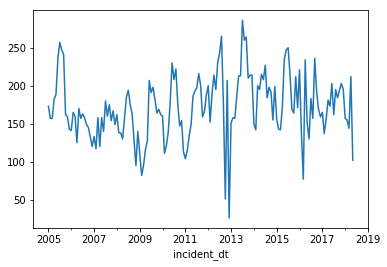

In [14]:
larceny_monthly_counts.plot()

In [15]:
larceny_result_add = seasonal_decompose(larceny_monthly_counts, model='additive')

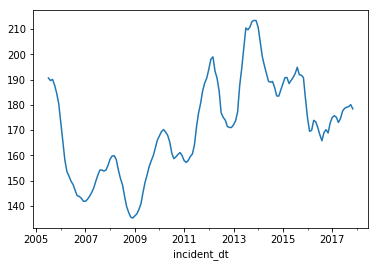

In [16]:
larceny_result_add.trend.plot()

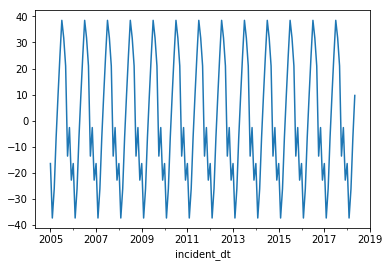

In [17]:
larceny_result_add.seasonal.plot()

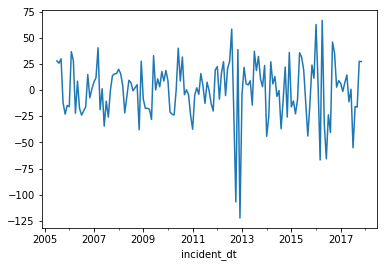

In [18]:
larceny_result_add.resid.plot()

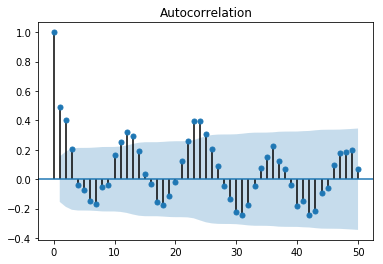

In [34]:
fig = plot_acf(larceny_monthly_counts, lags=50)

## burgerly over time

Definition. The FBI's Uniform Crime Reporting (UCR) Program defines burglary as the unlawful entry of a structure to commit a felony or theft. To classify an offense as a burglary, the use of force to gain entry need not have occurred.

In [23]:
burgerly_incidents = df[df['offense_group_short_description'] == 'BURGLARY']

In [24]:
burgerly_incidents['incident_dt'].count()

10039

In [25]:
burgerly_monthly_counts = burgerly_incidents['offense_short_description'].resample('M').count()

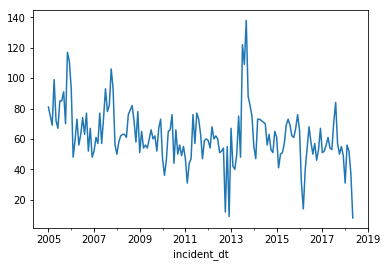

In [26]:
burgerly_monthly_counts.plot()

In [27]:
burgerly_result_add = seasonal_decompose(burgerly_monthly_counts, model='additive')

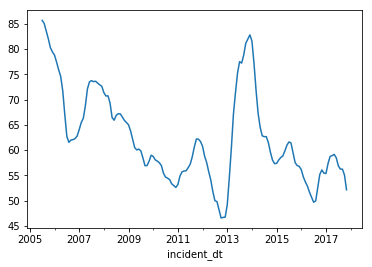

In [28]:
burgerly_result_add.trend.plot()

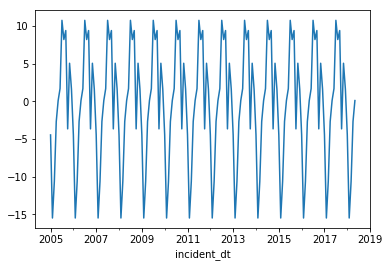

In [29]:
burgerly_result_add.seasonal.plot()

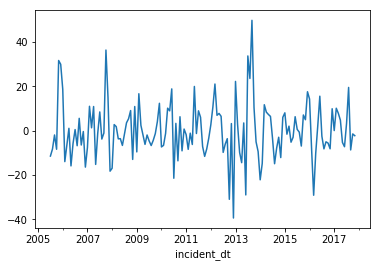

In [30]:
burgerly_result_add.resid.plot()

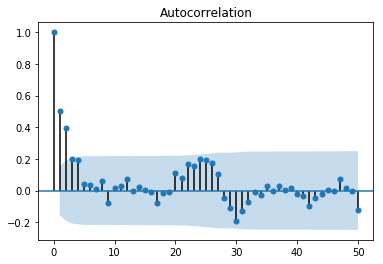

In [35]:
fig = plot_acf(burgerly_monthly_counts, lags=50)